In [1]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "20g")
    .getOrCreate()
)

In [2]:
levels = spark.read.json("../data/all_levels_20210801.json", multiLine=True).cache()
levels.printSchema()
levels.show(n=5)

root
 |-- level: long (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

+-----+-------+-------------------+
|level|   name|          timestamp|
+-----+-------+-------------------+
|  200|Unlucky|2016-08-07 16:27:09|
|  199|Unlucky|2016-07-24 12:45:27|
|  198|Unlucky|2016-07-14 07:50:14|
|  197|Unlucky|2016-06-24 00:51:22|
|  196|Unlucky|2016-06-09 07:10:15|
+-----+-------+-------------------+
only showing top 5 rows



In [3]:
ranking = spark.read.json("../data/all_ranking_20210731_deduped.json", multiLine=True).cache()
ranking.printSchema()
ranking.show(n=5)

root
 |-- fame: long (nullable = true)
 |-- guild: string (nullable = true)
 |-- job: string (nullable = true)
 |-- level: long (nullable = true)
 |-- mastery: string (nullable = true)
 |-- name: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- specialization: string (nullable = true)

+----+-------+--------+-----+----------+--------+----+--------------+
|fame|  guild|     job|level|   mastery|    name|rank|specialization|
+----+-------+--------+-----+----------+--------+----+--------------+
| 420|Project|magician|  200|    bishop| Unlucky|   1|        cleric|
|2714|   Noir|   thief|  200|night lord|    Babo|   2|      assassin|
| 784|   Noir|   thief|  200|night lord|    Nude|   3|      assassin|
|1135|   Noir|magician|  200|    bishop| JayChou|   4|        cleric|
| 263|Project|  bowman|  200| bowmaster|Zeretius|   5|        hunter|
+----+-------+--------+-----+----------+--------+----+--------------+
only showing top 5 rows



In [4]:
islander_ranking = spark.read.json("../data/islander_ranking_20210521.json", multiLine=True).cache()

In [5]:
levels.createOrReplaceTempView("levels")
ranking.createOrReplaceTempView("ranking")
islander_ranking.createOrReplaceTempView("islander_ranking")

exptable = spark.read.csv("../data/exptable.csv", header=True, inferSchema=True).cache()
exptable.createOrReplaceTempView("exptable")

In [6]:
islander_ranking.count()

1144

In [32]:
df = spark.sql("""
with names as (
    select distinct name 
    from islander_ranking
),
activity as (
    select
        name,
        timestamp
    from levels
    right join names
    using (name)
),
date_range as (
    select sequence(to_date(min(timestamp)), to_date(max(timestamp)), interval 1 day) as dates
    from activity
),
dates as (
    select date
    from date_range
    lateral view explode (dates) t as date
),
characters_active as (
    select
        name,
        date,
        datediff(date, max(timestamp)) as last_active_days
    from activity
    cross join dates
    where timestamp <= date
    group by 1, 2
    order by 1, 2
)
select
    date,
    count(distinct if(last_active_days < 28, name, null)) as n_active,
    count(distinct name) as n_total
from characters_active
group by 1
order by 1
""").toPandas()
df

,date,n_active,n_total
0,2015-10-14,1,1
1,2015-10-15,1,1
2,2015-10-16,3,3
3,2015-10-17,5,5
4,2015-10-18,6,6
...,...,...,...
2114,2021-07-28,39,1132
2115,2021-07-29,39,1132
2116,2021-07-30,37,1132
2117,2021-07-31,35,1132


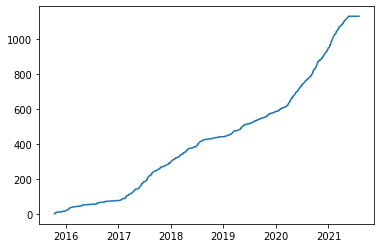

In [34]:
plt.plot(df.date, df.n_total)
plt.show()

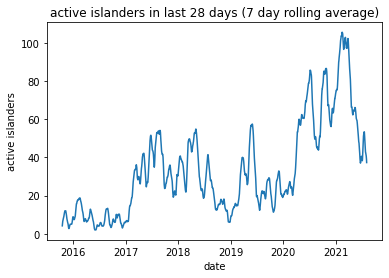

In [39]:
plt.plot(df.date, df.n_active.rolling(7).mean())
plt.title("active islanders in last 28 days (7 day rolling average)")
plt.xlabel("date")
plt.ylabel("active islanders")
plt.show()

In [7]:
df = spark.sql("""
with names as (
    select distinct name 
    from ranking
),
activity as (
    select
        name,
        timestamp
    from levels
    right join names
    using (name)
),
date_range as (
    select sequence(to_date(min(timestamp)), to_date(max(timestamp)), interval 1 day) as dates
    from activity
),
dates as (
    select date
    from date_range
    lateral view explode (dates) t as date
),
characters_active as (
    select
        name,
        date,
        datediff(date, max(timestamp)) as last_active_days
    from activity
    cross join dates
    where timestamp <= date
    group by 1, 2
    order by 1, 2
)
select
    date,
    count(distinct if(last_active_days < 28, name, null)) as n_active,
    count(distinct name) as n_total
from characters_active
group by 1
order by 1
""").toPandas()

In [8]:
df

,date,n_active,n_total
0,2015-10-14,205,205
1,2015-10-15,330,330
2,2015-10-16,408,408
3,2015-10-17,499,499
4,2015-10-18,580,580
...,...,...,...
2115,2021-07-29,10509,201198
2116,2021-07-30,10437,201298
2117,2021-07-31,10381,201424
2118,2021-08-01,10271,201496


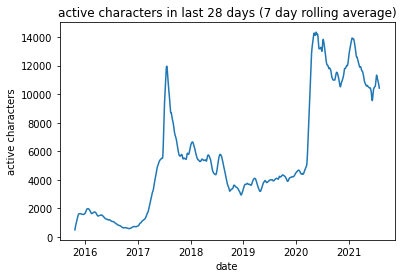

In [10]:
plt.plot(df.date, df.n_active.rolling(7).mean())
plt.title("active characters in last 28 days (7 day rolling average)")
plt.xlabel("date")
plt.ylabel("active characters")
plt.show()

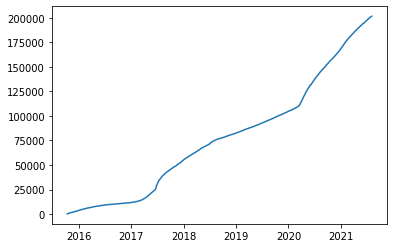

In [11]:
plt.plot(df.date, df.n_total)
plt.show()

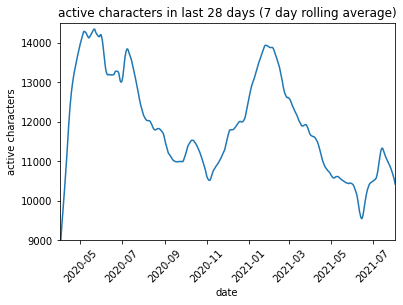

In [23]:
import datetime
plt.plot(df.date, df.n_active.rolling(7).mean())
plt.title("active characters in last 28 days (7 day rolling average)")
plt.xlabel("date")
plt.ylabel("active characters")
ax=plt.gca()
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2021, 8, 1)])
ax.set_ylim([9000, 14500])
plt.xticks(rotation=45)
plt.show()